In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor, Normalize, Compose
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

print('PyTorch version:', torch.__version__)
print('PyTorch working with CUDA:', torch.cuda.is_available())

PyTorch version: 2.9.0+cu130
PyTorch working with CUDA: True


In [2]:
# Ordered list of data labels as per Fashion MNIST Documentation
data_labels = ["T-Shirt", "Trouser", "Pullover", "Dress", "Coat", "Sandal",
               "Shirt", "Sneaker", "Bag", "Ankle Boot"]

# Data pre-processing transformations
transforms = Compose([
    ToTensor(), 
    Normalize(mean=0.5, std=0.5)
])

# Initialise data
training_data = datasets.FashionMNIST(
    root = "data",
    train = True,
    download = True,
    transform = transforms
)

test_data = datasets.FashionMNIST(
    root = "data",
    train = False,
    download = True,
    transform = transforms
)

# Batch Size (default = 64)
batch_size = 64

# Load the data with automatic shuffling for training
train_loader = DataLoader(training_data, batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size, shuffle=False)


train_images, train_labels = next(iter(train_loader))
test_images, test_labels = next(iter(test_loader))

# Tests
train_expected_size = torch.Size([batch_size,1,28,28])
assert train_images.shape == train_expected_size

expected_label_size = torch.Size([batch_size])
assert train_labels.shape == expected_label_size

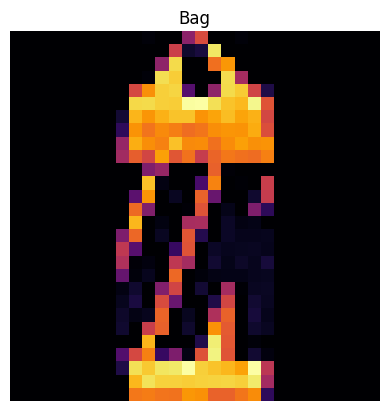

In [3]:
# Plot of random sample with label
img = train_images[0].squeeze()
label = data_labels[train_labels[0]]

fig = plt.imshow(img)
plt.axis('off')
fig.axes.get_xaxis().set_visible(False)
fig.axes.get_yaxis().set_visible(False)
plt.set_cmap('inferno')
plt.title(label)
plt.show()

In [ ]:
# Define a class for an MLP (dropout optional)
class MultilayerPerceptron(nn.Module):
    def __init__(self, hidden1,hidden2,hidden3,in_features=28*28, out_features=10,use_dropout=False):
        '''
        Multi-Layer Perceptron with specifiable hidden layer sizes
        Args:
            hidden1 (int): specify the number of neurons in layer 1
            hidden2 (int): specify the number of neurons in layer 2
            hidden3 (int): specify the number of neurons in layer 3
            in_features (int/optional): specify the number of inputs (size of flattened image = length * width)
            out_features (int/optional): specify the number of outputs (number of classes)
            use_dropout (bool/optional): enable dropout with p=0.2
        '''
        super().__init__()
        self.flatten = nn.Flatten()
        if use_dropout:
            self.lin_relu_stack = nn.Sequential(
                nn.Linear(in_features,hidden1),
                nn.ReLU(),
                nn.Dropout(0.2),
                nn.Linear(hidden1, hidden2),
                nn.ReLU(),
                nn.Dropout(0.2),
                nn.Linear(hidden2,hidden3),
                nn.ReLU(),
                nn.Dropout(0.2),
                nn.Linear(hidden3, out_features),
            )
        else:
            self.lin_relu_stack = nn.Sequential(
                nn.Linear(in_features, hidden1),
                nn.ReLU(),
                nn.Linear(hidden1, hidden2),
                nn.ReLU(),
                nn.Linear(hidden2, hidden3),
                nn.ReLU(),
                nn.Linear(hidden3, out_features)
             )

    def forward(self, x):
        '''
        Perform a forward pass of the network.
        Note: This flattens the image for us so we need not reshape input data.
        Args:
            x (tensor): datapoint from our data
        '''
        x = self.flatten(x)
        output = self.lin_relu_stack(x)
        output = F.log_softmax(output, dim=1)
        return output

In [ ]:
# define our CNN Architecture
class CNNNetwork(nn.Module):
    '''
    Defines a simple Convolutional Neural Network with 2 convolution layers and 2 instances of MaxPooling. Dropout p=0.2 in the dense layers.
    Args:
    in_channels (int): number of input channels. 1 for greyscale, 3 for rgb images etc.
    out_channels (int): number of classes
    filters1 (int): number of filters in convolution layer 1
    filters2 (int): number of filters in convolution layer 2
    kernel1 (int/tuple): kernel size in conv layer 1
    kernel2 (int/tuple): kernel size in conv layer 2
    stride1 (int): stride for conv layer 1
    stride2 (int): stride for conv layer 2
    '''
    def __init__(self,in_channels,out_channels,filters1,filters2,kernel1,kernel2,stride1,stride2):
        super().__init__()
        self.convstack = nn.Sequential(
            nn.Conv2d(in_channels,filters1,kernel1),
            nn.MaxPool2d(2,2),
            nn.Conv2d(filters1,filters2,kernel2),
            nn.MaxPool2d(2,2),
        )
        self.flatten = nn.Flatten()
        self.dense = nn.Sequential(
            nn.Linear(filters2*5*5,128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128,84),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(84,out_channels),
        )
    def forward(self,x):
        output = self.convstack(x)
        output = self.flatten(output)
        output = self.dense(output)
        output = F.log_softmax(output,dim=1)
        return output

In [ ]:
# Define a train and test function for use with our models
def train(dataloader, model, loss_fn, optimizer):
    '''
    Perform a simple training pass for one epoch
    Args:
        dataloader (Dataloader(data)): Dataloader using torchvision
        model (ANN/CNN): Chosen model
        loss_fn: Loss function used
        optim: optimiser used for gradient parameter adjustment
    '''
    model.train()
    num_batch = len(dataloader)
    train_loss = 0
    for X,label in dataloader:
        optimizer.zero_grad()
        pred = model(X)
        loss = loss_fn(pred, label)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= num_batch
    print(f'Training loss = {train_loss:>5f}')
    return train_loss

def test(dataloader, model,loss_fn):
    '''
    Perform a test pass.
    Args:
        dataloader (DataLoader(data)): Dataloader of a dataset using torchvision
        model (ANN/CNN): Chosen model
    '''
    model.eval()
    num_batch = len(dataloader)
    samples = len(dataloader.dataset)
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for X,label in dataloader:
            pred = model(X)
            loss = loss_fn(pred, label)
            test_loss += loss.item()
            pred = pred.argmax(1)
            correct += (pred == label).type(torch.float).sum().item()
    test_loss /= num_batch
    accuracy = correct/samples * 100
    print(f'Test loss = {test_loss:>5f} (Accuracy = {accuracy:.2f}%)')
    return test_loss, accuracy

In [ ]:
# Train/test loop combined, we will use accuracy as our primary metric
def run(train_loader,test_loader, model, epochs,loss_fn,optimizer):
    '''
    Runs our model train and test loop for a specified number of epochs
    Args:
    train_loader (Dataloader(data)): Training data
    test_loader (Dataloader(data)): Test data
    model (MultilayerPerceptron): Model
    epochs (int): Number of epochs
    '''
    loss_hist = []
    accuracy_hist = []
    for e in range(epochs):
        print(f'Epoch {e+1}/{epochs}')
        train_loss = train(train_loader, model, loss_fn, optimizer)
        test_loss, test_accuracy = test(test_loader, model,loss_fn)
        loss_hist.append([train_loss,test_loss])
        accuracy_hist.append(test_accuracy)
    return loss_hist, accuracy_hist

In [ ]:
# Confusion matrix plotter
def ConfM(dataloader, model):
    '''
    Create a confusion matrix and plot
    Args:
        dataloader (Dataloader(data)): Option to use a custom dataloader for test data
        model (ANN/CNN): Model
    '''
    predictions = []
    labels = []
    for data, label in dataloader:
        pred = model(data)
        pred = pred.argmax(1)
        predictions+=pred.tolist()
        labels+=label.tolist()
    cm = confusion_matrix(labels,predictions)
    ConfusionMatrixDisplay(cm, display_labels=data_labels).plot(xticks_rotation='vertical',cmap = 'inferno')

In [ ]:
# Initialise ANN and show structure
ann_model = MultilayerPerceptron(392,196,98)
print(ann_model)

# Hyperparameters
learn_rate = 1e-3
epochs = 25

# initialise loss function and optimiser
loss_fn = nn.NLLLoss()
optimizer = torch.optim.Adam(ann_model.parameters(), lr=learn_rate)

MultilayerPerceptron(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (lin_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=392, bias=True)
    (1): ReLU()
    (2): Linear(in_features=392, out_features=196, bias=True)
    (3): ReLU()
    (4): Linear(in_features=196, out_features=98, bias=True)
    (5): ReLU()
    (6): Linear(in_features=98, out_features=10, bias=True)
  )
)


In [17]:
# Train and test the model based on hyperparameters
ann_hist, ann_accuracy = run(train_loader,test_loader,ann_model,epochs,loss_fn,optimizer)

Epoch 1/25
Training loss = 0.502758
Test loss = 0.470710 (Accuracy = 83.24%)
Epoch 2/25
Training loss = 0.373597
Test loss = 0.418198 (Accuracy = 84.88%)
Epoch 3/25
Training loss = 0.335824
Test loss = 0.356838 (Accuracy = 86.91%)
Epoch 4/25
Training loss = 0.308144
Test loss = 0.374892 (Accuracy = 86.14%)
Epoch 5/25
Training loss = 0.291162
Test loss = 0.352719 (Accuracy = 87.17%)
Epoch 6/25
Training loss = 0.275366
Test loss = 0.336128 (Accuracy = 88.10%)
Epoch 7/25
Training loss = 0.258264
Test loss = 0.353969 (Accuracy = 87.81%)
Epoch 8/25
Training loss = 0.245602
Test loss = 0.351648 (Accuracy = 87.68%)
Epoch 9/25
Training loss = 0.232314
Test loss = 0.346518 (Accuracy = 88.35%)
Epoch 10/25
Training loss = 0.223914
Test loss = 0.366468 (Accuracy = 87.89%)
Epoch 11/25
Training loss = 0.210584
Test loss = 0.359250 (Accuracy = 88.15%)
Epoch 12/25
Training loss = 0.202835
Test loss = 0.339418 (Accuracy = 88.98%)
Epoch 13/25
Training loss = 0.190523
Test loss = 0.354975 (Accuracy = 88.

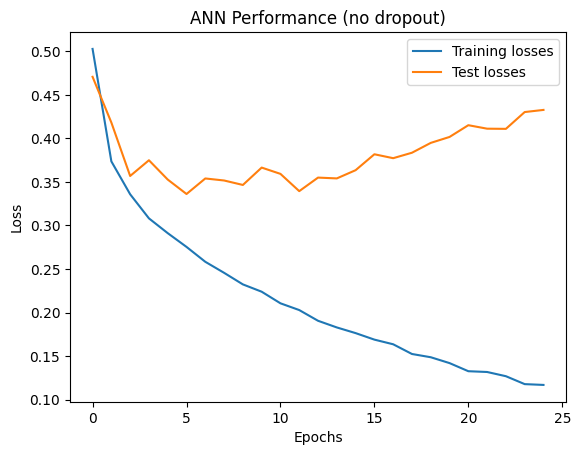

In [18]:
# plot loss history against epochs
plt.plot(ann_hist, label=["Training losses","Test losses"])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("ANN Performance (no dropout)")
plt.legend()
plt.show()

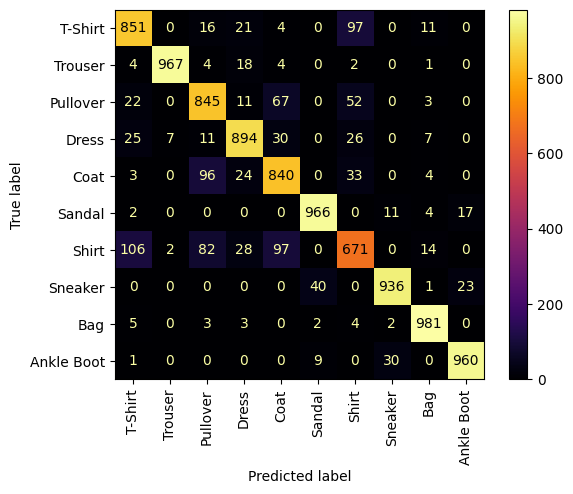

In [ ]:
# plot confusion matrix for our first model
ConfM(test_loader,ann_model)

In [141]:
# define a new ANN with dropout for comparison
ann_dropout = MultilayerPerceptron(392,196,98,use_dropout=True)
print(ann_dropout)
dropout_optimizer = torch.optim.Adam(ann_dropout.parameters(), lr=learn_rate)

MultilayerPerceptron(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (lin_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=392, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=392, out_features=196, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=196, out_features=98, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=98, out_features=10, bias=True)
  )
)


In [ ]:
# train and test
dropout_hist, dropout_accuracy = run(train_loader,test_loader,ann_dropout,epochs,loss_fn,dropout_optimizer)

Epoch 1/25
Training loss = 0.567230
Test loss = 0.436116 (Accuracy = 84.19%)
Epoch 2/25
Training loss = 0.421464
Test loss = 0.401751 (Accuracy = 85.15%)
Epoch 3/25
Training loss = 0.385685
Test loss = 0.416131 (Accuracy = 84.72%)
Epoch 4/25
Training loss = 0.363226
Test loss = 0.377838 (Accuracy = 86.36%)
Epoch 5/25
Training loss = 0.347248
Test loss = 0.394773 (Accuracy = 86.09%)
Epoch 6/25
Training loss = 0.332752
Test loss = 0.348148 (Accuracy = 87.48%)
Epoch 7/25
Training loss = 0.316704
Test loss = 0.340583 (Accuracy = 87.70%)
Epoch 8/25
Training loss = 0.309386
Test loss = 0.346789 (Accuracy = 88.01%)
Epoch 9/25
Training loss = 0.302125
Test loss = 0.339799 (Accuracy = 87.66%)
Epoch 10/25
Training loss = 0.294556
Test loss = 0.332500 (Accuracy = 88.02%)
Epoch 11/25
Training loss = 0.288399
Test loss = 0.321567 (Accuracy = 88.32%)
Epoch 12/25
Training loss = 0.280171
Test loss = 0.349414 (Accuracy = 87.60%)
Epoch 13/25
Training loss = 0.274100
Test loss = 0.329275 (Accuracy = 88.

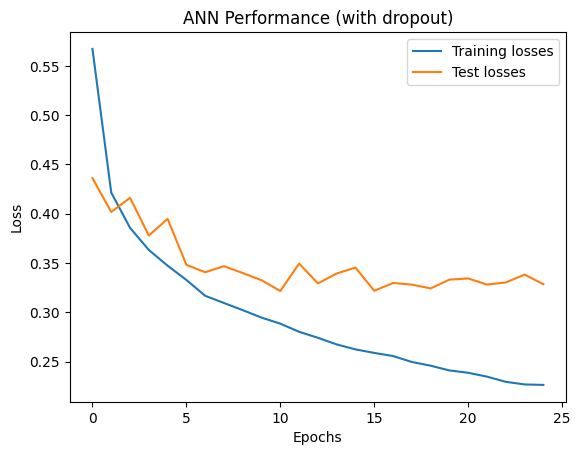

In [ ]:
# plot loss history
plt.plot(dropout_hist, label=["Training losses","Test losses"])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("ANN Performance (with dropout)")
plt.legend()
plt.show()

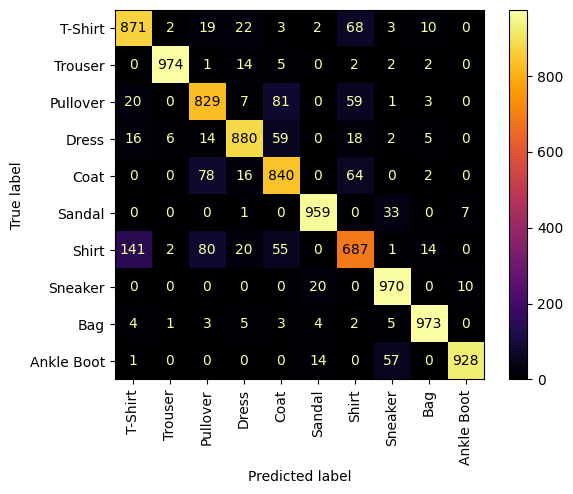

In [ ]:
# confusion matrix
ConfM(test_loader,ann_dropout)

In [ ]:
# initialise with hyperparameters
cnn = CNNNetwork(1,10,32,64,3,3,1,1)
print(cnn)
loss_fn = nn.NLLLoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr=learn_rate)
epochs = 10

CNNNetwork(
  (convstack): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dense): Sequential(
    (0): Linear(in_features=1600, out_features=128, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=128, out_features=84, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=84, out_features=10, bias=True)
  )
)


In [ ]:
# train and test
cnn_hist, cnn_accuracy = run(train_loader,test_loader,cnn,epochs,loss_fn,optimizer)

Epoch 1/10
Training loss = 0.514846
Test loss = 0.360371 (Accuracy = 86.70%)
Epoch 2/10
Training loss = 0.343038
Test loss = 0.321629 (Accuracy = 87.84%)
Epoch 3/10
Training loss = 0.296204
Test loss = 0.277788 (Accuracy = 89.82%)
Epoch 4/10
Training loss = 0.264866
Test loss = 0.276761 (Accuracy = 89.93%)
Epoch 5/10
Training loss = 0.241928
Test loss = 0.283363 (Accuracy = 90.04%)
Epoch 6/10
Training loss = 0.218901
Test loss = 0.261320 (Accuracy = 90.40%)
Epoch 7/10
Training loss = 0.199726
Test loss = 0.269165 (Accuracy = 90.71%)
Epoch 8/10
Training loss = 0.185138
Test loss = 0.286225 (Accuracy = 90.54%)
Epoch 9/10
Training loss = 0.169210
Test loss = 0.269739 (Accuracy = 91.12%)
Epoch 10/10
Training loss = 0.158839
Test loss = 0.281932 (Accuracy = 90.84%)


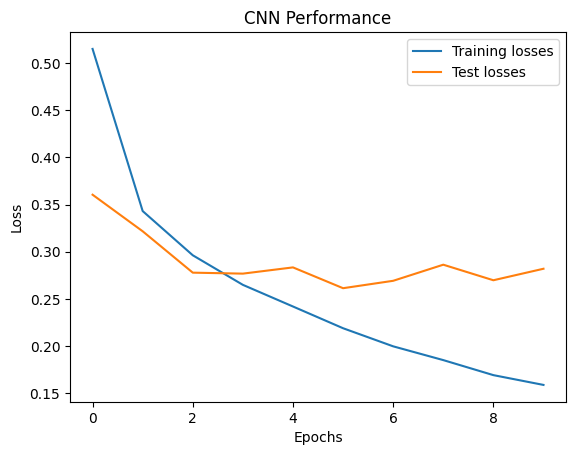

In [142]:
# plot loss history
plt.plot(cnn_hist, label=["Training losses","Test losses"])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("CNN Performance")
plt.legend()
plt.show()

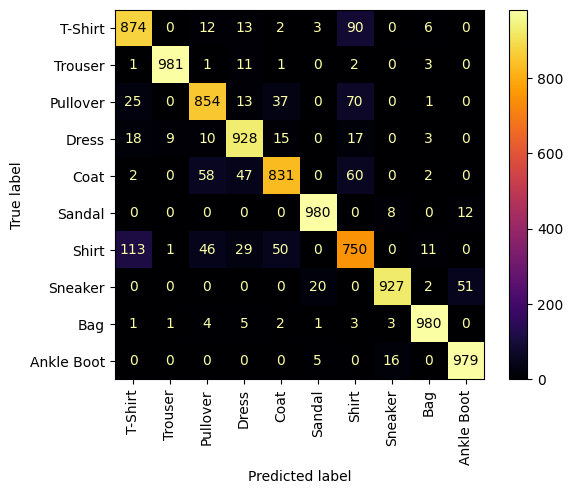

In [143]:
# confusion matrix
ConfM(test_loader,cnn)